In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

In [2]:
# Directory path where the CSV files are located
directory = r'C:\Users\raulo\Desktop\CódigoTese\tracks'

# List to store the individual DataFrames
dfs = []

# Get the list of file names in alphabetical order
file_names = sorted(os.listdir(directory))

# Iterate over the files in the directory
for filename in file_names:
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        #print(file_path)
        df = pd.read_csv(file_path, header = 2)
        df = df.drop(0)
        df.index = df.index -1    #Set the index rigth
        df = df.drop(columns='bodyparts')
        dfs.append(df)


C:\Users\raulo\AppData\Local\Temp\ipykernel_9208\821610458.py:15: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header = 2)
C:\Users\raulo\AppData\Local\Temp\ipykernel_9208\821610458.py:15: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header = 2)
C:\Users\raulo\AppData\Local\Temp\ipykernel_9208\821610458.py:15: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header = 2)
C:\Users\raulo\AppData\Lo

In [3]:
# Directory path where the CSV files are located
directory = r'C:\Users\raulo\Desktop\CódigoTese\Labels'

# List to store the individual DataFrames
dfs_labels = []

# Get the list of file names in alphabetical order
file_names = sorted(os.listdir(directory))

# Iterate over the files in the directory
for filename in file_names:
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        df = df.drop(columns='Unnamed: 0')
        #print(file_path)
        dfs_labels.append(df)

In [4]:
dfs_labels_single = []
for df in dfs_labels:
    # Convert DataFrame into a single-column DataFrame
    single_column_df = pd.DataFrame(df.idxmax(axis=1), columns=['Interaction'])
    dfs_labels_single.append(single_column_df)

In [5]:
# Create a list to store the labeled DataFrames
labeled_dfs = []

# Iterate over the DataFrames
for i in range(len(dfs)):
    # Add the labels DataFrame in front of each DataFrame
    labeled_df = pd.concat([dfs_labels_single[i], dfs[i]], axis=1)
    labeled_dfs.append(labeled_df)

# Concatenate the labeled DataFrames vertically
merged_df = pd.concat(labeled_dfs, ignore_index=True)

# Print the merged DataFrame
#print(merged_df)

In [6]:
interaction_counts = merged_df['Interaction'].value_counts()
print(interaction_counts)

background     594156
Int_Client       5524
TS               1474
Int_Cleaner       955
Jolt              490
Run               145
Name: Interaction, dtype: int64


# XGBoost

In [7]:
X = merged_df.iloc[:, 1:43]  # Select columns 1 to 42 as features
y = merged_df.iloc[:, 0]     # Select column 0 as the target variable

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1999)

In [9]:
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [14]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)


In [15]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming you have your feature matrix X_train and target variable y_train

# Create the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_imputed, label=y_train_encoded)
dtest = xgb.DMatrix(X_test_imputed, label=y_test_encoded)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Multiclass classification objective
    'num_class': len(np.unique(y_train_encoded)),  # Number of classes
    'eval_metric': 'merror'  # Metric for evaluation
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Convert predicted labels to integers
y_pred = y_pred.astype(int)

NameError: name 'y_pred_encoded' is not defined

In [16]:
# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9992451202415615


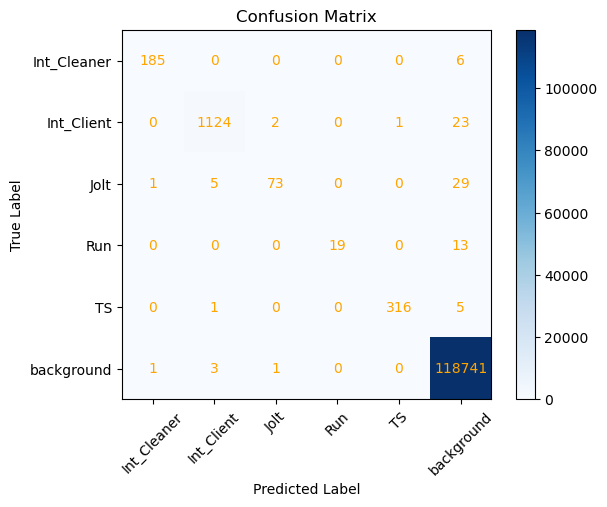

In [22]:
cm = confusion_matrix(y_test_encoded, y_pred)

# Define the class labels
class_labels = np.sort(merged_df['Interaction'].unique())

# Create the confusion matrix
cm = np.array(cm)

# Create a figure and axis
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Set axis labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, rotation=45)
ax.set_yticklabels(class_labels)

# Add labels to each cell
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color='orange')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set title and labels
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()


# XGBoost (all Columns) with 5k backgrounds

In [24]:
background_df = merged_df[merged_df['Interaction'] == 'background']
other_df = merged_df[merged_df['Interaction'] != 'background']

desired_background_samples = 5000

background_sample = background_df.sample(n=desired_background_samples, random_state=1999)

undersampled_df = pd.concat([background_sample, other_df], ignore_index=True)

In [25]:
interaction_counts_new = undersampled_df['Interaction'].value_counts()
print(interaction_counts_new)

Int_Client     5524
background     5000
TS             1474
Int_Cleaner     955
Jolt            490
Run             145
Name: Interaction, dtype: int64


In [27]:
X_new5000 = undersampled_df.iloc[:, 1:43]  # Select columns 1 to 42 as features
y_new5000 = undersampled_df.iloc[:, 0]     # Select column 0 as the target variable

X_train_new5000, X_test_new5000, y_train_new5000, y_test_new5000 = train_test_split(X_new5000, y_new5000, test_size=0.2, random_state=1999)

In [28]:
y_train_new5000_encoded = label_encoder.fit_transform(y_train_new5000)
y_test_new5000_encoded = label_encoder.fit_transform(y_test_new5000)

In [29]:
X_train_imputed_new5000 = imputer.fit_transform(X_train_new5000)
X_test_imputed_new5000 = imputer.transform(X_test_new5000)

In [30]:
# Assuming you have your feature matrix X_train and target variable y_train

# Create the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_imputed_new5000, label=y_train_new5000_encoded)
dtest = xgb.DMatrix(X_test_imputed_new5000, label=y_test_new5000_encoded)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Multiclass classification objective
    'num_class': len(np.unique(y_train_new5000_encoded)),  # Number of classes
    'eval_metric': 'merror'  # Metric for evaluation
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Convert predicted labels to integers
y_pred = y_pred.astype(int)

In [31]:
# Calculate accuracy
accuracy = accuracy_score(y_test_new5000_encoded, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9885945548197204


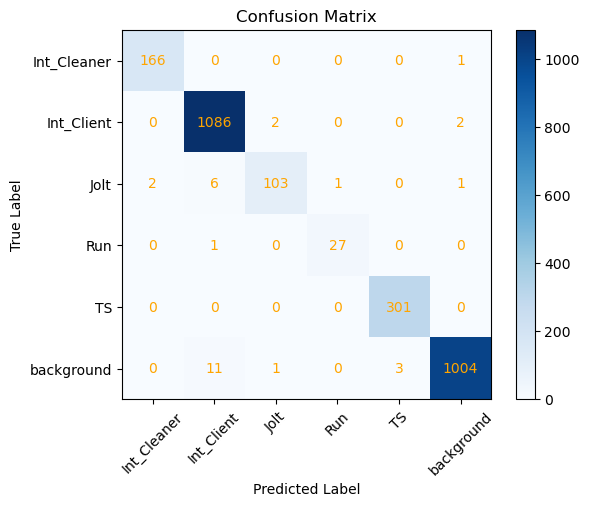

In [32]:
cm = confusion_matrix(y_test_new5000_encoded, y_pred)

# Define the class labels
class_labels = np.sort(merged_df['Interaction'].unique())

# Create the confusion matrix
cm = np.array(cm)

# Create a figure and axis
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Set axis labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, rotation=45)
ax.set_yticklabels(class_labels)

# Add labels to each cell
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color='orange')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set title and labels
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()


# XGBoost (Columns likelihood out) with 5k backgrounds


In [33]:
columns = [1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23,25,26,28,29,31,32,34,35,37,38,40,41]

In [34]:
X_new5000_featuresselection = undersampled_df.iloc[:, columns]  # Select columns 1 to 42 as features
y_new5000_featuresselection = undersampled_df.iloc[:, 0]     # Select column 0 as the target variable

In [36]:
X_train_new5000_featuresselection, X_test_new5000_featuresselection, y_train_new5000_featuresselection, y_test_new5000_featuresselection = train_test_split(X_new5000_featuresselection, y_new5000_featuresselection, test_size=0.2, random_state=1999)

In [37]:
X_train_imputed_new5000_featuresselection = imputer.fit_transform(X_train_new5000_featuresselection)
X_test_imputed_new5000_featuresselection = imputer.transform(X_test_new5000_featuresselection)

In [38]:
y_train_new5000_featuresselection_encoded = label_encoder.fit_transform(y_train_new5000_featuresselection)
y_test_new5000_featuresselection_encoded = label_encoder.fit_transform(y_test_new5000_featuresselection)

In [39]:
# Assuming you have your feature matrix X_train and target variable y_train

# Create the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_imputed_new5000_featuresselection, label=y_train_new5000_featuresselection_encoded)
dtest = xgb.DMatrix(X_test_imputed_new5000_featuresselection, label=y_test_new5000_featuresselection_encoded)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Multiclass classification objective
    'num_class': len(np.unique(y_train_new5000_encoded)),  # Number of classes
    'eval_metric': 'merror'  # Metric for evaluation
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Convert predicted labels to integers
y_pred = y_pred.astype(int)

In [40]:
# Calculate accuracy
accuracy = accuracy_score(y_test_new5000_featuresselection_encoded, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9893303899926417


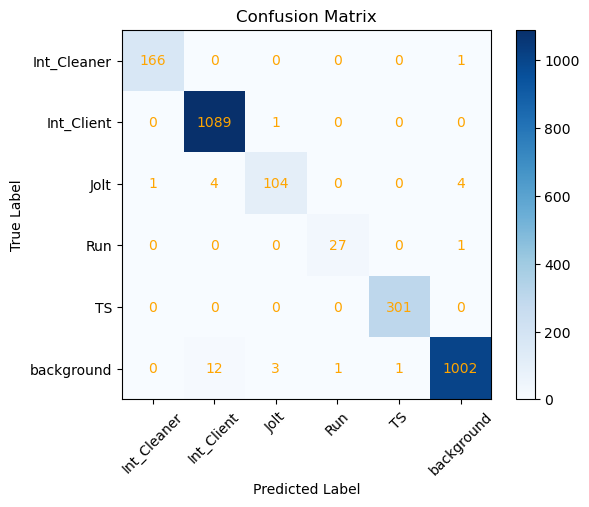

In [41]:
cm = confusion_matrix(y_test_new5000_featuresselection_encoded, y_pred)

# Define the class labels
class_labels = np.sort(merged_df['Interaction'].unique())

# Create the confusion matrix
cm = np.array(cm)

# Create a figure and axis
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Set axis labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, rotation=45)
ax.set_yticklabels(class_labels)

# Add labels to each cell
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color='orange')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set title and labels
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()
